In [243]:
#Importing Libraries
import pandas as pd          
import numpy as np          # For mathematical calculations
import matplotlib.pyplot as plt  # For plotting graphs
from datetime import datetime    # To access datetime
from pandas import Series        # To work on series
import matplotlib
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [244]:
df = pd.read_csv('PRSA_data.csv')

df = df.drop(['Ir','No','Is'],axis = 1)

#Changing the column names
cnames = list(df.columns)

#Drop the first row 
df = df[24:]

df.dtypes

df.reset_index(inplace = True)
df = df.drop(['index'], axis = 1)

df_new = df[['year', 'month', 'day', 'hour']]
df_new['date'] = pd.to_datetime(df_new)

df['date'] = df_new['date']

#Set the date as Index
df = df.set_index(df['date'],drop = False)
df = df.sort_index()

# df_cbwd = df['cbwd']
# df_cbwd['cbwd_mode'] = df_cbwd.resample("d").apply(lambda x: stats.mode(x)[0])

# df = df.resample('d').mean()
# df['cbwd'] = df_cbwd['cbwd_mode']

df['day_of_week'] = df.index.dayofweek

def weekend(row):
    if (row == 5) or (row == 6):
        return 1
    else:
        return 0

df['weekend'] = df['day_of_week'].apply(weekend)


mean = df['pm2.5'].min()
std_dev = df['pm2.5'].max() - df['pm2.5'].min()

for field in cnames:
    print(field, df[field].isna().sum())

df['pm2.5'] = df['pm2.5'].fillna(df['pm2.5'].mean())

df = pd.get_dummies(df, columns = ['cbwd'] )    

df['PM2.5'] = df['pm2.5']
df = df.drop(['pm2.5'], axis = 1)

df = df.drop(['hour', 'date'], axis = 1)

cnames = list(df.columns)

year 0
month 0
day 0
hour 0
pm2.5 2043
DEWP 0
TEMP 0
PRES 0
cbwd 0
Iws 0


In [245]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02 00:00:00,2010,1,2,-16,-4.0,1020.0,1.79,5,1,0,0,1,0,129.0
2010-01-02 01:00:00,2010,1,2,-15,-4.0,1020.0,2.68,5,1,0,0,1,0,148.0
2010-01-02 02:00:00,2010,1,2,-11,-5.0,1021.0,3.57,5,1,0,0,1,0,159.0
2010-01-02 03:00:00,2010,1,2,-7,-5.0,1022.0,5.36,5,1,0,0,1,0,181.0
2010-01-02 04:00:00,2010,1,2,-7,-5.0,1022.0,6.25,5,1,0,0,1,0,138.0


In [246]:
df = df.resample('d').mean()

In [247]:
df.head()

,year,month,day,DEWP,TEMP,PRES,Iws,day_of_week,weekend,cbwd_NE,cbwd_NW,cbwd_SE,cbwd_cv,PM2.5
date,,,,,,,,,,,,,,
2010-01-02,2010.0,1.0,2.0,-8.500000,-5.125000,1024.750000,24.860000,5.0,1.0,0.000,0.000000,1.00,0.000000,145.958333
2010-01-03,2010.0,1.0,3.0,-10.125000,-8.541667,1022.791667,70.937917,6.0,1.0,0.000,0.166667,0.75,0.083333,78.833333
2010-01-04,2010.0,1.0,4.0,-20.875000,-11.500000,1029.291667,111.160833,0.0,0.0,0.000,1.000000,0.00,0.000000,31.333333
2010-01-05,2010.0,1.0,5.0,-24.583333,-14.458333,1033.625000,56.920000,1.0,0.0,0.375,0.583333,0.00,0.041667,42.458333
2010-01-06,2010.0,1.0,6.0,-23.708333,-12.541667,1033.750000,18.511667,2.0,0.0,0.500,0.416667,0.00,0.083333,56.416667


In [248]:
df = df.iloc[:-2,:]

In [249]:
for field in cnames:
    df[field] = (df[field] - df[field].min())/(df[field].max() - df[field].min())

In [250]:
train_x = df['PM2.5'][:-4]
test_x = df['PM2.5'][-4:]
train_x.head()

date
2010-01-02    0.269502
2010-01-03    0.142996
2010-01-04    0.053476
2010-01-05    0.074443
2010-01-06    0.100749
Freq: D, Name: PM2.5, dtype: float64

In [251]:
test_x.head()

date
2014-12-26    0.315282
2014-12-27    0.444222
2014-12-28    0.366403
2014-12-29    0.294080
Freq: D, Name: PM2.5, dtype: float64

In [252]:
train_x.shape

(1819,)

In [253]:
#'''PROPHET GENERAL MODEL'''
from fbprophet import Prophet
pro_train = pd.DataFrame(index = range(0,len(train_x)))
pro_train['ds'] = train_x.index
pro_train['y'] = train_x.values

prop = Prophet(weekly_seasonality = True)
prop.fit(pro_train)
future = prop.make_future_dataframe(periods = 4)
forecast = prop.predict(future)
print(forecast.shape)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


(1823, 19)


In [254]:
forecast = forecast.set_index(forecast['ds'])
#forecast = forecast['2015']
#forecast = forecast['2015-10-25':]
forecast_extracted = forecast[-4:]
print(forecast_extracted.shape)

(4, 19)


In [255]:
forecast_extracted.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')

In [256]:
y_test = test_x
y_hat = forecast_extracted['yhat'].values
y_hat_upper = forecast_extracted['yhat_upper'].values
y_hat_lower = forecast_extracted['yhat_lower'].values

In [257]:
y_hat = (y_hat*std_dev)+mean
y_test = (y_test*std_dev)+mean
y_hat_upper = (y_hat_upper*std_dev)+mean
y_hat_lower = (y_hat_lower*std_dev)+mean

In [258]:
print(y_hat)
print(y_test.values)

[137.03389538 147.18649659 142.74732041 137.52425906]
[313.39075108 441.55703085 364.20454409 292.31590605]


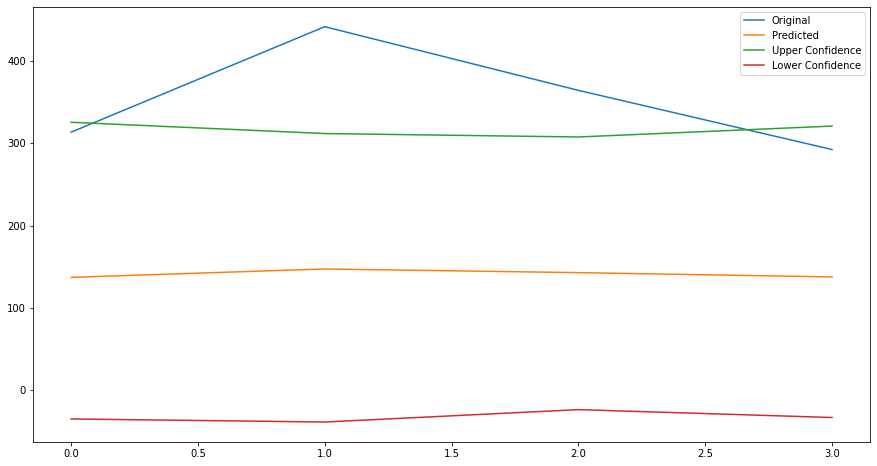

In [259]:
plt.plot(y_test.values, label = 'Original')
plt.plot(y_hat, label = 'Predicted')
plt.plot(y_hat_upper, label = 'Upper Confidence')
plt.plot(y_hat_lower, label = 'Lower Confidence')
plt.legend()
plt.show()

In [260]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from math import sqrt
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


rms_new = sqrt(mean_squared_error(y_test, y_hat))
print(rms_new)

mse_new = mean_squared_error(y_test, y_hat)
print(mse_new)

mae_new = mean_absolute_error(y_test, y_hat)
print(mae_new)

mape_new = mean_absolute_percentage_error(y_test, y_hat)
print(mape_new)

218.38012036663827
47689.87697134742
211.74406515420102
59.17488719929176
